# Locus coeruleus on functional 7T NTNU data 

 by Anne C. Trutti
 
 based on code by Steven Miletic 
 
 
 Date: 23-03-2021


## 1. Group ICA on rs data in order to check for LC component

 ### preprocessing
 1. [x] bring individual resting state runs into MNI space
     --> rerun fmriprep so that functional runs of anatomical session are also stored (we do not store them by default to server RAM/memory limitations) 
 2. [x] denoise data       
 3. [x] extract brainstem mask from Harvard-Oxford atlas 
 4. [x] binarise brainstem mask
 5. [x] warp MNI05 1mm to MNI09cAsym 1mm template 
 6. [x] apply same warp to brainstem mask
 7. [x] Register MNI05 0.5mm to MNI09c 
 8. [x] apply same warp to LC mask
 9. [x] downsample resulting masks to 1.5mm 
 10. [x] mask brainstem for each sub and each run
 
### independent component analysis

 11. [x] fit melodic ICA 
 12. [x] plot and save individual components
 13. [x] FWE-correct IC maps
 14. [x] plot and save individual, corrected components
 
         

# 2. some checks

1. [x] register LC prob atlas to each individual functional run
2. [x] tSNR in LC voxels
3. [x] register VTA and SN atlases (0p5 mni09b --> 1p5mm mni09c space)

In [18]:

import nighres
import re
import os
import shutil
import nibabel as nib
import numpy as np
import nilearn
from nighres.registration import embedded_antsreg, apply_coordinate_mappings
from nilearn import plotting
from nilearn.input_data import NiftiMasker
import nibabel as nib
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
## 1

# see 01_nifti2bids_mriqc_fmriprep in tux18 in /home/Public/trondheim/scripts

# dicom --> nifti
# bids formatting
# mriqc
# fmriprep --> rerun for anatomical sessions only

# !docker run -ti --rm -v /home/Public/trondheim/derivatives/bids_anat:/data:ro \
# -v /home/Public/trondheim/derivatives/fmriprep_anat:/out \
# -v /home/Public/trondheim/fmriprep_work_anat:/work \
# -v /home/Public/trondheim/license.txt:/license.txt \
# poldracklab/fmriprep:latest /data /out --fs-license-file /license.txt -w /work --output-spaces T1w MNI152NLin2009cAsym --no-submm-recon \
# participant --participant_label 002 003 004 005 006 007 008 009 010 011

In [59]:
# 2 denoise data 

subjects = ['002', 
            '003', 
            '004',
            '005',
            '006',
            '007',
            '008',
            '009',
            '010',
            '011']

ses = 'anatomical'
task = 'rs'
runs = [1,2]
include_physio=True
space = 'MNI152NLin2009cAsym' #'T1w'

#for subject_id in subjects:
for sub in subjects:
   # print(sub)
    subject_id = 'sub-'+ str(sub)  
    print(subject_id)
    
    main_dir = '/home/Public/trondheim/derivatives/fmriprep_anat/fmriprep'
    sub_dir = main_dir +'/'+ str(subject_id)
    save_dir =  '/home/atrutti1/Documents/trondheim/LC_ICA/rs_runs/denoised'+'/'+ str(subject_id)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    
    for run in runs:
        print(run)
        
        # point to data
        confounds_fn = f'/home/Public/trondheim/derivatives/fmriprep_anat/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
        func_fn = f'/home/Public/trondheim/derivatives/fmriprep_anat/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz'
        brain_mask_fn = func_fn.replace('preproc_bold', 'brain_mask')
        confounds = pd.read_csv(confounds_fn, sep='\t')[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement']].fillna(method='bfill')
        # get retroicor
        if include_physio:
            retroicor_fn = f'/home/Public/trondheim/derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv'
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
            confounds = pd.concat([confounds, retroicor], axis=1)
        nii = nib.load(func_fn)
        brain_mask = nib.load(brain_mask_fn)
        # High-pass filtering: [from fsl melodic]
        # Since we don't have a model of the signal we expect to see in the data, we only want to remove slow drifts. 
        # Also, resting state signal is low frequency, mostly between 0.01-0.1 Hz, so we want to remove frequencies only below 0.01 Hz (corresponding to a period of 100 s).
        masker = NiftiMasker(mask_img=brain_mask, t_r=1.38, high_pass=1./128) # =.0078
        # Generate & fit NiftiMasker
        filtered_data = masker.fit_transform(nii, confounds=confounds)
        # back to brain space
        inver = masker.inverse_transform(filtered_data)
        # add mean of timeseries per voxel back
        filtered_data_brainspace = inver.get_fdata() + np.mean(nii.get_fdata(), 3)[:,:,:,np.newaxis]
        filtered_nii = nib.Nifti1Image(filtered_data_brainspace, inver.affine, header=nii.header)

        fn = f'sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-{space}_desc-preproc_bold_filtered'
        #save file
        nib.save(filtered_nii, save_dir +'/'+ fn +'.nii.gz' )
    


sub-002
1
2
sub-003
1
2
sub-004
1
2
sub-005
1
2
sub-006
1
2
2
sub-010
1
2
sub-011
1
2


In [16]:
# 3

# cd /home/atrutti1/Documents/trondheim/LC_ICA/brainstem_masks/Harvard-Oxford

#fslmaths /usr/local/fsl/6.0/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz -thr 8 -uthr 8.1 brainstem_mask.niigz

In [17]:
# 4 

# fslmaths brainstem_mask.nii.gz -bin brainstem_mask_bin.nii.gz



In [20]:
# BET and save MNI templates

#warp MNI05, the space from which the brainstem mask was taken, 
#to MNI09cAsym template, the standard space the individual functional
#runs have been registered to in step #1


template_dir = '/home/atrutti1/Documents/trondheim/LC_ICA/Templates/'

## All anatomical images to register
mni05_brain = os.path.join(template_dir, 'MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz')  # 1 mm

mni09c = os.path.join(template_dir, 'mni_icbm152_nlin_asym_09c_nifti', 'mni_icbm152_nlin_asym_09c', 'mni_icbm152_t1_tal_nlin_asym_09c.nii')
mni09c_brain_mask = os.path.join(template_dir, 'mni_icbm152_nlin_asym_09c_nifti', 'mni_icbm152_nlin_asym_09c', 'mni_icbm152_t1_tal_nlin_asym_09c_mask.nii')

def mask_and_save(img, mask):
    img_hdr = nib.load(img)
    mask_hdr = nib.load(mask)
    
    img_data = img_hdr.get_data()
    mask_data = mask_hdr.get_data()
    
    img_data[mask_data.astype(bool)==False] = 0
    
    img_nii = nib.Nifti1Image(img_data, img_hdr.affine)
    nib.save(img_nii, img.replace('.nii', '_brain.nii'))
    
    return img.replace('.nii', '_brain.nii')

mni09c_brain = mask_and_save(mni09c, mni09c_brain_mask)


registration_dir = '../registration'
if not os.path.exists(registration_dir):
    os.makedirs(registration_dir)
    
 

<ipython-input-20-f38a86fc055f>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img_data = img_hdr.get_data()
<ipython-input-20-f38a86fc055f>:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask_data = mask_hdr.get_data()


In [22]:
# 5
# warp MNI05 1mm to MNI09cAsym 1mm template 

### Register MNI05 1mm to MNI09c (syn)
syn_res = embedded_antsreg(source_image=mni05_brain,
                           target_image=mni09c_brain,
                           output_dir=registration_dir,
                           file_name='mni05_to_mni09c',
                           save_data=True, 
                           overwrite=False)


#worked


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to ../registration/

Saving ../registration/mni05_to_mni09c_tmp_srccoord.nii.gz

Saving ../registration/mni05_to_mni09c_tmp_trgcoord.nii.gz
registering /home/atrutti1/Documents/trondheim/LC_ICA/Templates/MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz
 to /home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output mni05_to_mni09c_tmp_syn --transform SyN[0.2, 4.0, 3.0] --metric MI[/home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii, /home/atrutti1/Documents/trondheim/LC_ICA/Templates/MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz, 1.000, 32, Random, 0.3 ] --convergence [40x40x50x40, 1e-06, 5

In [23]:
# 6 

# apply same warp to brainstem mask


roi_dict_mni05 = {
    'brainstem': '../brainstem_masks/Harvard-Oxford/brainstem_mask_bin.nii.gz'
#     'rSTR': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_MP2RAGE_STR_interrater_prop_R_normalized_1mm.nii.gz',
#     'lSTN': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_FLASH_STh_interrater_prop_L_normalized_1mm.nii.gz',
#     'rSTN': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_FLASH_STh_interrater_prop_R_normalized_1mm.nii.gz',
#     'lPreSMA': './masks/orig_Boekel_et_al/03_PreSMA_L.nii.gz',
#     'rPreSMA': './masks/orig_Boekel_et_al/04_PreSMA_R.nii.gz',
#     'lGPi': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPi_interrater_prop_L_normalized_1mm.nii.gz',
#     'rGPi': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPi_interrater_prop_R_normalized_1mm.nii.gz',
#     'lGPe': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPe_interrater_prop_L_normalized_1mm.nii.gz',
#     'rGPe': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPe_interrater_prop_R_normalized_1mm.nii.gz',
#     'rIFG': './masks/modified_from_harvard_oxford/IFG_R_prob_map.nii.gz',
#     'ACC': './masks/original_harvard_oxford_mni05/ACC_prob_map.nii.gz',
#     'M1': './masks/modified_from_BNA/M1_prob_map.nii.gz',
#     'rM1': './masks/modified_from_BNA/rM1_prob_map.nii.gz',
#     'lM1': './masks/modified_from_BNA/lM1_prob_map.nii.gz',
#     'THA': './masks/modified_from_harvard_oxford/Thalamus_prob_map.nii.gz'
}

#mapping1 = registration_dir + '/mni05_0p4_to_mni05_1p0_ants-map.nii.gz'
mapping2 = registration_dir + '/mni05_to_mni09c_ants-map.nii.gz'

redo = False
final_masks_mni09c_1mm = '../brainstem_masks/Harvard-Oxford/final_masks_mni09c_1mm'

if not os.path.exists(final_masks_mni09c_1mm):
    os.makedirs(final_masks_mni09c_1mm)

for mask, fn in roi_dict_mni05.items():
    if 'PreSMA' in mask:
        # two mappings
        apply_coordinate_mappings(fn, mapping1=mapping1, mapping2=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)
    else:
        # single mapping
        apply_coordinate_mappings(fn, mapping1=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ../brainstem_masks/Harvard-Oxford/final_masks_mni09c_1mm/
skip computation (use existing results)


In [21]:
# 7
### Register MNI05 0.5mm to MNI09c 
mni05_icbm152_p5mm = '../LC_prob_atlas/LC_7T_prob/mni_icbm152_t1_tal_nlin_asym_09b_hires_FSL_bbox_struc_brain_CSFin.nii'

syn_res = embedded_antsreg(source_image=mni05_icbm152_p5mm,
                           target_image=mni09c_brain,
                           output_dir=registration_dir,
                           file_name='mni05p5_to_mni09c',
                           save_data=True, 
                           overwrite=False)



Embedded ANTs Registration Multi-contrasts

Outputs will be saved to ../registration/
skip computation (use existing results)


In [23]:
# 8 

# apply same warp to LC mask


roi_dict_mni0p5 = {
    'LC': '../LC_prob_atlas/LC_7T_prob/LCTMP_n53_5SD_prob0.nii.gz'}



#mapping1 = registration_dir + '/mni05_0p4_to_mni05_1p0_ants-map.nii.gz'
mapping2 = registration_dir + '/mni05p5_to_mni09c_ants-map.nii.gz'

redo = False
final_masks_mni09c_1mm = '../LC_prob_atlas/LC_7T_prob/final_masks_mni09c_1mm'

if not os.path.exists(final_masks_mni09c_1mm):
    os.makedirs(final_masks_mni09c_1mm)

for mask, fn in roi_dict_mni0p5.items():
    if 'PreSMA' in mask:
        # two mappings
        apply_coordinate_mappings(fn, mapping1=mapping1, mapping2=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)
    else:
        # single mapping
        apply_coordinate_mappings(fn, mapping1=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ../LC_prob_atlas/LC_7T_prob/final_masks_mni09c_1mm/

Saving ../LC_prob_atlas/LC_7T_prob/final_masks_mni09c_1mm/LC_def-img.nii.gz


In [24]:
# 7 downsample resulting MNI09c brain to 1.5mm 

##  MNI09c -> MNI09c 1p5mm (BOLD-resolution)
#Select any BOLD-image (that was registered to MNI09c-space) and run embedded_syn without any iterations to resample in 1p5mm space

ref_bold = '/home/Public/trondheim/derivatives/fmriprep_anat/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz'
#not the bold run but the *_boldref.nii.gz

syn_res = embedded_antsreg(source_image=mni09c_brain,
                           target_image=ref_bold,
                           rigid_iterations=0, 
                           coarse_iterations=0,
                           medium_iterations=0,
                           fine_iterations=0,
                           run_rigid=True,
                           run_syn=False,
                           run_affine=False,
                           save_data=True,
                           output_dir=registration_dir,
                           file_name='mni09c_1mm_to_mni09c_1p5mm',
                           overwrite=True)

#probably won't work 
# mni09c_2_1p5mm_svg = make_report(fixed_image=ref_bold, 
#                                  moving_image='../registration/mni09c_to_mni09c_1p5mm_ants-def.nii.gz', #syn_res['transformed_source'],
#                                  output_dir=registration_dir, fn='mni09c_to_mni09c_1p5mm.svg')
# from IPython.display import SVG, display
# display(SVG(mni09c_2_1p6mm_svg))


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to ../registration/

Saving ../registration/mni09c_1mm_to_mni09c_1p5mm_tmp_srccoord.nii.gz

Saving ../registration/mni09c_1mm_to_mni09c_1p5mm_tmp_trgcoord.nii.gz
registering /home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii
 to /home/Public/trondheim/derivatives/fmriprep_anat/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output mni09c_1mm_to_mni09c_1p5mm_tmp_syn --transform Rigid[0.1] --metric MI[/home/Public/trondheim/derivatives/fmriprep_anat/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz, /home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin

In [25]:
# 9a

### Apply transforms to each mask; save again
# mapping1 = os.path.join(registration_dir, 'mni05_0p4_to_mni05_1p0_ants-map.nii.gz')
mapping2 = os.path.join(registration_dir, 'mni05_to_mni09c_ants-map.nii.gz')
mapping3 = os.path.join(registration_dir, 'mni09c_1mm_to_mni09c_1p5mm_ants-map.nii.gz')

final_masks_mni09c_1p5mm = '../registration/brainstem_masks/final_masks_mni09c_1p5mm'
if not os.path.exists(final_masks_mni09c_1p5mm):
    os.makedirs(final_masks_mni09c_1p5mm)

redo=True
for mask, fn in roi_dict_mni05.items():
    if 'PreSMA' in mask:
        apply_coordinate_mappings(fn, 
                          mapping1=mapping1,      # 05 p4 -> 05 1mm
                          mapping2=mapping2,      # 05 -> 09a
                          mapping3=mapping3,      # 09a 1mm -> 09a 1.6mm
                          save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                          overwrite=redo, padding='zero')
    else:
        apply_coordinate_mappings(fn, 
                                  mapping1=mapping2,   # 05 -> 09a
                                  mapping2=mapping3,   # 09a -> 09a 1.6mm
                                  save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                                  overwrite=redo, padding="zero")


Apply coordinate mappings

Outputs will be saved to ../registration/brainstem_masks/final_masks_mni09c_1p5mm/

Saving ../registration/brainstem_masks/final_masks_mni09c_1p5mm/brainstem_def-img.nii.gz


In [49]:
# 9b 

# LC 
# note, it requires a different mapping than the MNI05 atlas masks

### Apply transforms to each mask; save again
# mapping1 = os.path.join(registration_dir, 'mni05_0p4_to_mni05_1p0_ants-map.nii.gz')
mapping2 = os.path.join(registration_dir, 'mni05p5_to_mni09c_ants-map.nii.gz')
mapping3 = os.path.join(registration_dir, 'mni09c_1mm_to_mni09c_1p5mm_ants-map.nii.gz')

final_masks_mni09c_1p5mm = '../registration/LC_masks/final_masks_mni09c_1p5mm'
if not os.path.exists(final_masks_mni09c_1p5mm):
    os.makedirs(final_masks_mni09c_1p5mm)

redo=True
for mask, fn in roi_dict_mni0p5.items():
    if 'PreSMA' in mask:
        apply_coordinate_mappings(fn, 
                          mapping1=mapping1,      # 05 p4 -> 05 1mm
                          mapping2=mapping2,      # 05 -> 09a
                          mapping3=mapping3,      # 09a 1mm -> 09a 1.6mm
                          save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                          overwrite=redo, padding='zero')
    else:
        apply_coordinate_mappings(fn, 
                                  mapping1=mapping2,   # 05 -> 09a
                                  mapping2=mapping3,   # 09a -> 09a 1.6mm
                                  save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                                  overwrite=redo, padding="zero")


Apply coordinate mappings

Outputs will be saved to ../registration/LC_masks/final_masks_mni09c_1p5mm/

Saving ../registration/LC_masks/final_masks_mni09c_1p5mm/LC_def-img.nii.gz


In [ ]:
# don't need this


# #same for LC

# # downsample resulting MNI09c brain to 1.5mm 

# ref_bold = '/home/Public/trondheim/derivatives/fmriprep_anat/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz'
# #not the bold run but the *_boldref.nii.gz

# syn_res = embedded_antsreg(source_image=mni05_icbm152_p5mm,
#                            target_image=ref_bold,
#                            rigid_iterations=0, 
#                            coarse_iterations=0,
#                            medium_iterations=0,
#                            fine_iterations=0,
#                            run_rigid=True,
#                            run_syn=False,
#                            run_affine=False,
#                            save_data=True,
#                            output_dir=registration_dir,
#                            file_name='mni09c_1mm_to_mni09c_1p5mm',
#                            overwrite=True)

# #probably won't work 
# # mni09c_2_1p5mm_svg = make_report(fixed_image=ref_bold, 
# #                                  moving_image='../registration/mni09c_to_mni09c_1p5mm_ants-def.nii.gz', #syn_res['transformed_source'],
# #                                  output_dir=registration_dir, fn='mni09c_to_mni09c_1p5mm.svg')
# # from IPython.display import SVG, display
# # display(SVG(mni09c_2_1p6mm_svg))

In [62]:
# 10

# mask rs runs to only include brainstem voxels (Harvard-Oxford atlas)

#For each subject, mask voxels of brainstem for each rs run

subjects = ['sub-002', 
            'sub-003', 
            'sub-004',
            'sub-005',
            'sub-006',
            'sub-007',
            'sub-008',
            'sub-009',
            'sub-010',
            'sub-011']


for subject_id in subjects:
    print(subject_id)
    main_dir = '/home/atrutti1/Documents/trondheim/LC_ICA/rs_runs/denoised'
    sub_dir = main_dir +'/'+ str(subject_id)
    save_dir =  '/home/atrutti1/Documents/trondheim/LC_ICA/rs_runs/denoised'+'/'+ str(subject_id)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
   # print(sub_dir)
    
    # load individual reoriented and bet images 
    imgRS_run1 = nib.load(sub_dir + '/' + str(subject_id) + '_ses-anatomical_task-rs_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_filtered.nii.gz')
    imgRS_run2 = nib.load(sub_dir + '/' + str(subject_id) + '_ses-anatomical_task-rs_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_filtered.nii.gz')

    imgRS_run1_data = imgRS_run1.get_fdata()
    imgRS_run2_data = imgRS_run2.get_fdata()
    

    #load brainstem mask 
    brainstem_mask = nib.load('/home/atrutti1/Documents/trondheim/LC_ICA/registration/brainstem_masks/final_masks_mni09c_1p5mm/brainstem_def-img.nii.gz')
    brainstem_mask_data = brainstem_mask.get_fdata()
    
    
    # mask BOLD images
    # rs run 1
    masked_rs1 = imgRS_run1_data.copy()
    masked_rs1[brainstem_mask_data==0] = 0
    #store as nifti object
    masked_rs1_nii = nib.Nifti1Image(masked_rs1, affine=imgRS_run1.affine)

    # rs run 2
    masked_rs2 = imgRS_run2_data.copy()
    masked_rs2[brainstem_mask_data==0] = 0
    #store as nifti object
    masked_rs2_nii = nib.Nifti1Image(masked_rs2, affine=imgRS_run2.affine)


    
    #label file
    fn = str(subject_id) + '_ses-anatomical_task-rs_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_filtered_mask-brainstem'
    fni = str(subject_id) + '_ses-anatomical_task-rs_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_filtered_mask-brainstem'

    #save file
    nib.save(masked_rs1_nii, save_dir +'/'+ fn +'.nii.gz' )
    nib.save(masked_rs2_nii, save_dir +'/'+ fni +'.nii.gz' )


    

sub-002
sub-003
sub-005
sub-006
sub-007
sub-008
sub-009
sub-010
sub-011


### 11. now we can finally fit the ICA 

#### ICA with  30 components 

 fsl melodic

cd atrutti1@tux18psy:~/Documents/trondheim/LC_ICA/ICA/data

melodic -i rs_runs.txt -o ../ICA_output --tr=1.38 --report -d 30

output: melodic_IC.nii.gz 
--> is the  unthresholded z-map data

In [17]:
# let's look at the ICA output 

In [3]:
#nibabel
img_melodicICA=nib.load('/home/atrutti1/Documents/trondheim/LC_ICA/ICA/ICA_output/melodic_IC.nii.gz')


In [10]:
# 12 

#plot and save individual components

from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

save_dir = '/home/atrutti1/Documents/trondheim/LC_ICA/ICA/ICA_output/individual_components'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

for i, cur_img in enumerate(iter_img(img_melodicICA)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)
    fn = 'IC_' + str(i)
    nib.save(cur_img, save_dir +'/'+ fn +'.nii.gz' )

    

SyntaxError: invalid syntax (<ipython-input-10-b74a1f371318>, line 2)

In [29]:
thresholded_map3
threshold3

5.035008052588239

In [6]:
import nistats
from nistats.thresholding import map_threshold

save_dir ='/home/atrutti1/Documents/trondheim/LC_ICA/ICA/ICA_output/individual_components'


for i, cur_img in enumerate(iter_img(img_melodicICA)):
    thresholded_map, threshold = map_threshold(
        cur_img, alpha=.01, height_control='bonferroni')
    print('The p<.01 Bonferroni-corrected threshold is %.3g' % threshold)
    
    fn = 'IC_' + str(i) +'_FWE_corr'
    nib.save(thresholded_map, save_dir +'/'+ fn +'.nii.gz' )


The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni

### outcome:

could be independent component no. 12

let's try again with more components to be safe...

#### ICA with  50 components 


cd atrutti1@tux18psy:~/Documents/trondheim/LC_ICA/ICA

melodic -i rs_runs.txt -o ../ICA_output_d50 --tr=1.38 --report -d 50

/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:1608: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:607: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


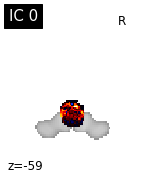

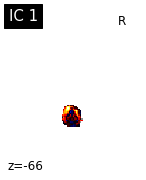

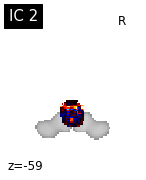

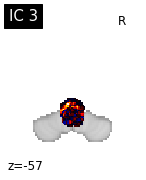

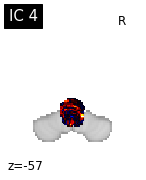

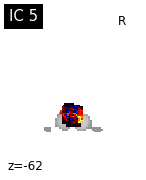

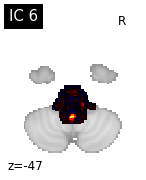

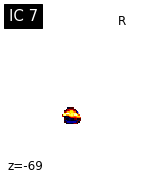

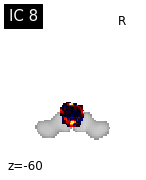

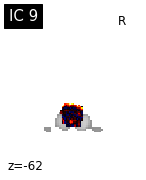

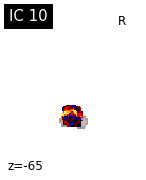

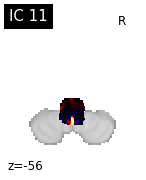

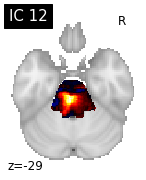

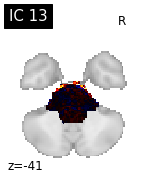

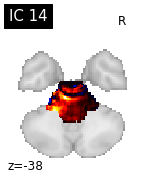

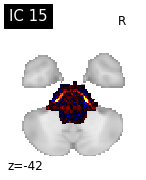

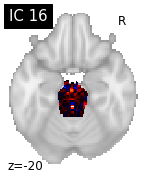

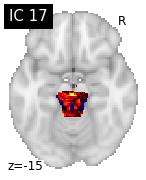

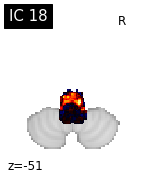

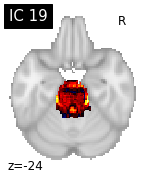

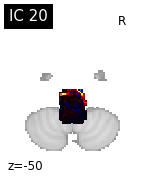

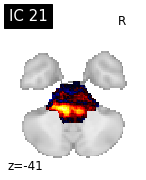

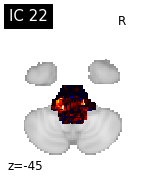

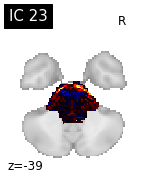

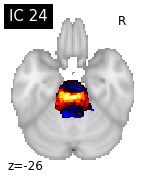

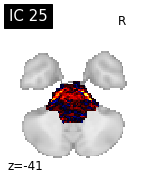

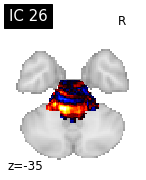

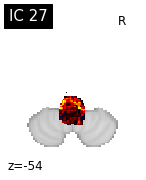

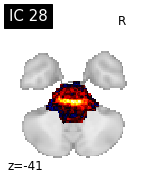

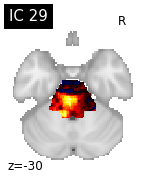

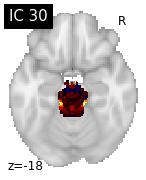

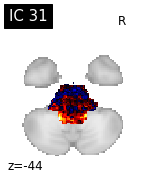

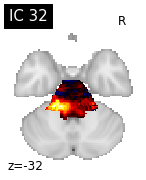

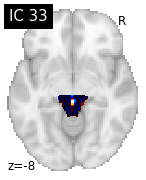

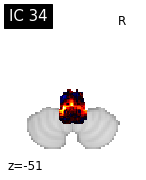

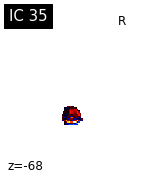

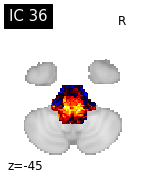

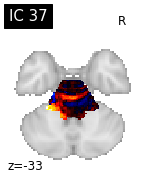

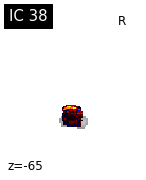

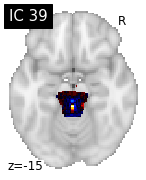

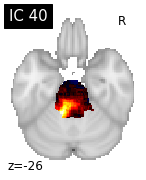

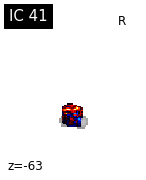

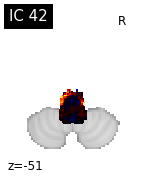

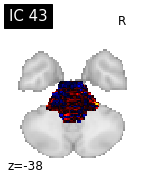

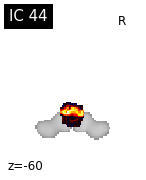

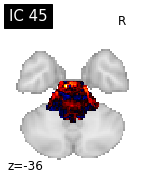

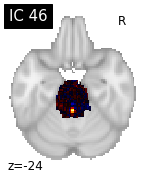

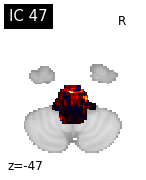

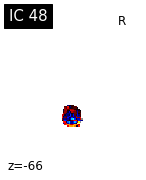

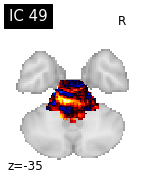

In [7]:
#plot and save individual components

img_melodicICA_d50 =nib.load('/home/atrutti1/Documents/trondheim/LC_ICA/ICA/ICA_output_d50/melodic_IC.nii.gz')

save_dir = '/home/atrutti1/Documents/trondheim/LC_ICA/ICA/ICA_output_d50/individual_components'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

for i, cur_img in enumerate(iter_img(img_melodicICA_d50)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)
    fn = 'IC_' + str(i)
    nib.save(cur_img, save_dir +'/'+ fn +'.nii.gz' )

    

The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni-corrected threshold is 5.03
The p<.01 Bonferroni

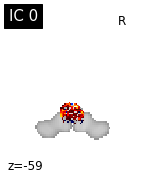

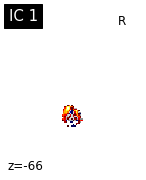

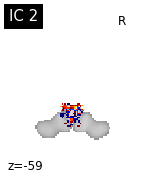

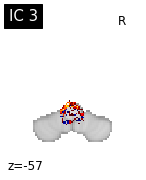

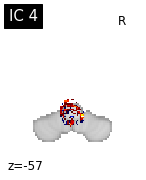

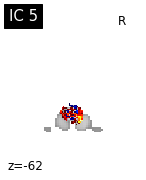

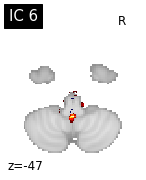

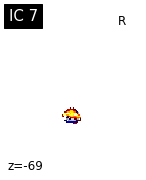

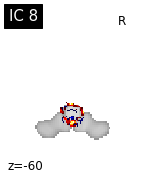

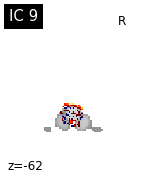

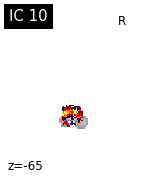

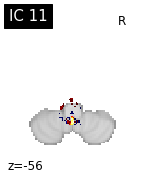

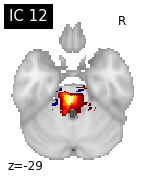

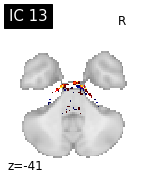

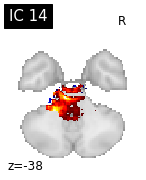

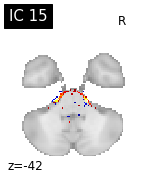

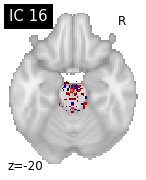

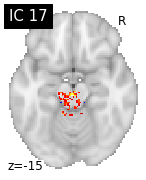

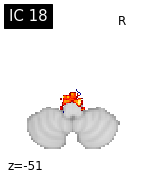

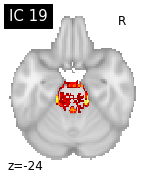

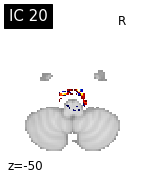

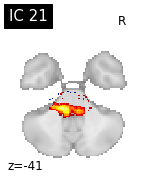

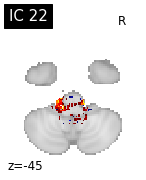

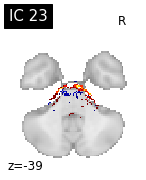

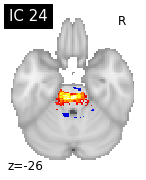

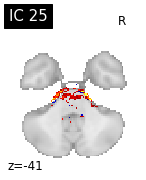

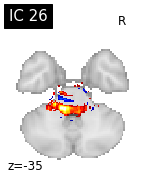

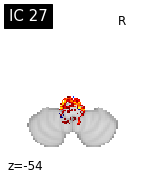

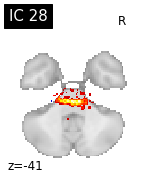

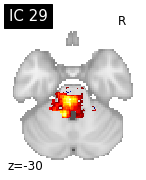

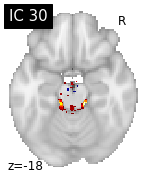

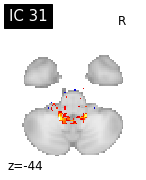

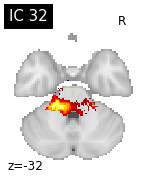

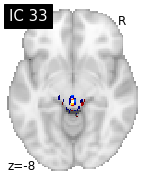

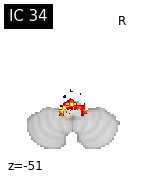

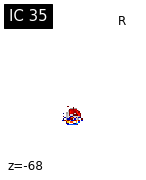

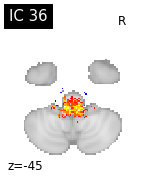

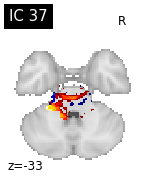

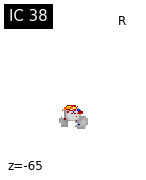

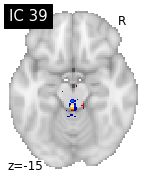

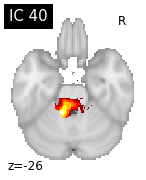

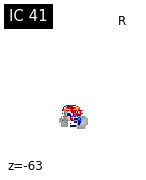

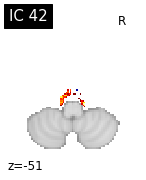

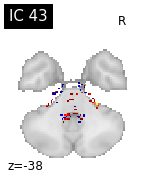

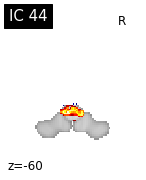

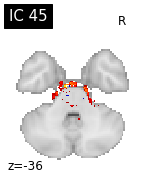

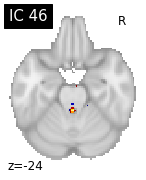

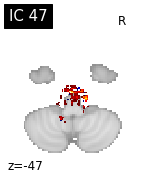

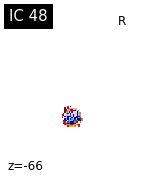

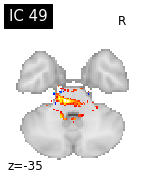

In [9]:

save_dir ='/home/atrutti1/Documents/trondheim/LC_ICA/ICA/ICA_output_d50/individual_components'


for i, cur_img in enumerate(iter_img(img_melodicICA_d50)):
    thresholded_map, threshold = map_threshold(
        cur_img, alpha=.01, height_control='bonferroni')
    plot_stat_map(thresholded_map, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)
    print('The p<.01 Bonferroni-corrected threshold is %.3g' % threshold)
    
    fn = 'IC_' + str(i) +'_FWE_corr'
    nib.save(thresholded_map, save_dir +'/'+ fn +'.nii.gz' )


In [ ]:

for i, cur_img in enumerate(iter_img(img_melodicICA_d50)):
    thresholded_map, threshold = map_threshold(
        cur_img, alpha=.01, height_control='bonferroni')
    plot_stat_map(thresholded_map, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)
   # print('The p<.01 Bonferroni-corrected threshold is %.3g' % threshold3)


### output: 
component 17

# some data checks
since we now have LC prob masks in MNI2009cAsym 1 mm space we can add it to the lists of masks and extact statistics such as tSNR;

--> We have all masks in MNI2009cAsym 1 mm space; hence, applying the composite warp to T1w and then the affine to functional data 

In [1]:
import glob
import os
import re
import shutil
import random
import string

import numpy as np
import pandas as pd

import nilearn
from nilearn import plotting, image
from nilearn.input_data import NiftiMasker
import nibabel as nib
from nipype.interfaces import ants
import nighres

# simple modeling
from nilearn.glm.first_level import FirstLevelModel #nilearn must be -v >= 0.7.0

import subprocess
import json
import multiprocessing as mp
from functools import partial
import joblib
from joblib import Parallel, delayed

# from utils import plot_spm
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# split the LC atlas into 2 unilateral masks

# cd /Documents/trondheim/LC_ICA/LC_prob_atlas/LC_7T_prob/final_masks_mni09c_1mm 

# HALFX = dim1 / 2 = 193/2 = 96,5
# --> until voxel n0 96 is

#fslmaths LC_def-img.nii.gz -roi 0 96 0 -1 0 -1 0 -1 mask-lLC.nii
#fslmaths LC_def-img.nii.gz -roi 95 96 0 -1 0 -1 0 -1 mask-rLC.nii


In [2]:
#set t1w_to_MNI to False because you’re going from MNI to t1w psace

def apply_warp(img, sub,
               t1w_to_MNI=False, interpolation='Linear'):
    ''' img can be a file path (preferred) OR a nifti1Image (which will be temporarily saved and then provided as a filepath to ants) '''
    from nipype.interfaces import ants
    print(sub)
    if isinstance(img, str):
        if not os.path.exists(img):
            raise(IOError('img must either be a string pointing to an existing file, or a Nifti1Image. You passed: {}'.format(img)))
        input_is_img = False
    elif isinstance(img, nib.Nifti1Image):
        # save file, use a random string in name
        import random
        import string

        tmp1_name = './tmp_img_to_warp-{}.nii.gz'.format(''.join(random.choices(string.ascii_letters + string.digits, k=10)))
        img.to_filename(tmp1_name)  # save to temporary file
        img = tmp1_name
        input_is_img = True
    else:
        raise(IOError('Input type not understood... img must either be a string pointing to an existing file, or a Nifti1Header. You passed: {}'.format(img)))
    
    # find affine & composite warp
    if t1w_to_MNI:
        ## warping an img from functional T1w space (1.5 mm) to MNI2009c (1 mm)
        composite_warp_name = 'from-T1w_to-MNI152NLin2009cAsym'
        template_brain = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
        out_postfix = '_warped_2_MNI2009c'
    else:
        ## warping an img from MNI2009c (1 mm) to functional T1w space (1.5 mm)
        composite_warp_name = 'from-MNI152NLin2009cAsym_to-T1w'
        # use first bold_ref as reference img
        boldrefs = sorted(glob.glob(os.path.join('/home/Public/trondheim', 'derivatives', 'fmriprep', 'fmriprep', f'sub-{sub}', 'ses-*', 'func', 
                                      'sub-*_ses-*_task-*_run-1_space-T1w_boldref.nii.gz')))
        print(boldrefs)
        template_brain = boldrefs[0]
        out_postfix = f'_warped_2_T1w_sub-{sub}'

    composite_xfm = os.path.join('/home/Public/trondheim/', 'derivatives', 'fmriprep', 'fmriprep', f'sub-{sub}', 'anat', 
                             f'sub-{sub}_{composite_warp_name}_mode-image_xfm.h5')
    
    output_img_name = os.path.basename(img).replace('.nii.gz', '') + out_postfix + '.nii.gz'
    
    # ants set-up
    warp = ants.ApplyTransforms()
    warp.inputs.input_image = img
    warp.inputs.input_image_type = 0
    warp.inputs.interpolation = interpolation
    warp.inputs.invert_transform_flags = [False] #,False]
    warp.inputs.reference_image = template_brain
    warp.inputs.out_postfix = out_postfix
    
    if t1w_to_MNI:
        warp.inputs.transforms = [composite_xfm]
    else:
        warp.inputs.transforms = [composite_xfm]
    
    res = warp.run()
    
    if input_is_img:
        os.remove(img)  # remove temporary file again, all we care is the output anyway
    return str(res.outputs.output_image)

In [5]:
#### Warp LC masks to individual subjects' T1w-spaces


In [4]:
# Note: cannot run subs with only anatomical session (anat folder in wrong place)
all_subjects = ['002', '003', '004', '005', '006', '007', '008', '009' , '011','015']

def warp_masks_2_t1w(sub, overwrite=False): 
   # print(sub)
    regex_masks = re.compile('/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym/space-MNI152NLin2009cAsym_label-(?P<label>\S+)_probseg.nii.gz')
    all_masks = sorted(glob.glob('/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym/*.nii.gz'))
    
    output_img_base = f'/home/Public/trondheim/derivatives/masks/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{label}}.nii.gz'
    
    for mask in all_masks:
        mask_label = regex_masks.match(mask).groupdict()['label']
        
        final_img_fn = output_img_base.format(label=mask_label)
        if not os.path.exists(final_img_fn) or overwrite:
            os.makedirs(os.path.dirname(final_img_fn), exist_ok=True)
            tmp_img_name = apply_warp(mask, sub=sub, t1w_to_MNI=False)
            shutil.move(tmp_img_name, final_img_fn)
            
# _ = [warp_masks_2_t1w(x) for x in all_subjects]

# with mp.Pool(20) as p:
#     p.map(warp_masks_2_t1w, all_subjects)

for sub in all_subjects:
    #print(sub)
   # print(mask)
    warp_masks_2_t1w(sub) 
    

002
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-rbrevl/func/sub-002_ses-rbrevl_task-rb_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-rbrevl/func/sub-002_ses-rbrevl_task-revl_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-rlsat/func/sub-002_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-sstmsit/func/sub-002_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-sstmsit/func/sub-002_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
002
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz'

007
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-anatomical/func/sub-007_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-rb_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-revl_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rlsat/func/sub-007_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
008
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-008/ses-anatomical/func/sub-008_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz'

In [8]:
def warp_massp_map(args, atlas, target_img):
    label_n, label = args
    random.seed(label_n)
    this_map = atlas.get_fdata().copy()
    this_map[this_map!=(label_n+1)] = 0
    this_map[this_map>0] = 1
    this_map_nii = nib.Nifti1Image(this_map, atlas.affine)

    # ok now we need to do this rather annoying temporary save thing agian
    tmp_name = './tmp_img_to_warp-{}.nii.gz'.format(''.join(random.choices(string.ascii_letters + string.digits, k=10)))
    this_map_nii.to_filename(tmp_name)

    out = nighres.registration.embedded_antsreg(source_image=tmp_name, 
                                                target_image=target_img,
                                                run_rigid=True, rigid_iterations=0, 
                                                run_affine=False, run_syn=False, overwrite=True, 
                                                interpolation='Linear', save_data=True, output_dir='./', file_name=f'{tmp_name}_warp.nii.gz')
    warped_img = out['transformed_sources'][0]
    warped_data = warped_img.get_fdata()

    # clean-up
    os.remove(tmp_name)
    os.remove(f'{tmp_name}_warp_ants-def0.nii.gz')
    os.remove(f'{tmp_name}_warp_ants-map.nii.gz')
    os.remove(f'{tmp_name}_warp_ants-invmap.nii.gz')
    return {label: nib.Nifti1Image(warped_data.copy(), header=warped_img.header, affine=warped_img.affine)}

def load_MASSP_atlas_1p5mm(sub):
    labels_17structures = ['Str-l','Str-r','STN-l','STN-r','SN-l','SN-r',\
                           'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
                           'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
                           'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
                           'PPN-l','PPN-r','Cl-l','Cl-r']

    # save fns
    save_fn_template = f'/home/Public/trondheim/derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{}}.nii.gz'
    if os.path.exists(save_fn_template.format('Str-l')):
        # Already warped, load atlas
        maps = {}
        for label in labels_17structures:
            maps[label] = nib.load(save_fn_template.format(label))
        
    else:
        atlas_fn = os.path.join('/home/Public/trondheim/', 'derivatives', 'nighres', f'sub-{sub}', 'ses-anatomical', 'subcortex', f'sub-{sub}_ses-anatomical_massp-labels.nii.gz')
        target_img = sorted(glob.glob(f'/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
        atlas = nib.load(atlas_fn)

        # now we need to reduce resolution to 1.5mm
        with mp.Pool(32) as p:
            maps = p.map(partial(warp_massp_map, atlas=atlas, target_img=target_img), enumerate(labels_17structures))
        maps = {list(x.keys())[0]: list(x.values())[0] for x in maps}
        
        # save
        os.makedirs(os.path.dirname(save_fn_template), exist_ok=True)
        for label in labels_17structures:
            maps[label].to_filename(save_fn_template.format(label))

    return maps

In [9]:
all_subjects = ['002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016']# , '018', '019']
for subject in all_subjects:
    print(subject)
    load_MASSP_atlas_1p5mm(subject)

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016


In [10]:
def find_rois(sub, atlas_name='ATAG', space='T1w'):
    if atlas_name == 'ATAG':
        if space == 'MNI152NLin2009cAsym' or space == 'mni':
            ### Rois in MNI09c-space
            mask_dir='/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym_res-1p5'
            fns = sorted(glob.glob(mask_dir + '/space-*'))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_res-1p5_label-(?P<label>[a-zA-Z0-9]+)_probseg_def-img.nii.gz', fn).groupdict()['label'] for fn in fns]
        else:
            mask_dir = f'/home/Public/trondheim/derivatives/masks/sub-{sub}/anat/sub-{sub}_*.nii.gz'
            fns = sorted(glob.glob(mask_dir))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>[a-zA-Z0-9]+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'MASSP':
        mask_dir = f'/home/Public/trondheim/derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]

    roi_dict = dict(zip(names, fns))
    return roi_dict

def load_atlas(sub, atlas_name='MASSP', space='T1w'):
    from nilearn import image
    
    roi_dict = find_rois(sub, atlas_name, space)
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas

/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


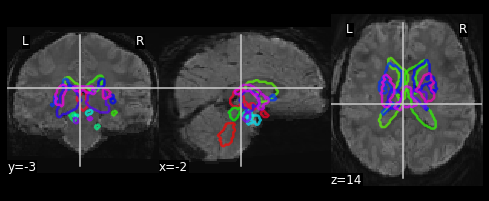

In [11]:
sub = '011'
boldref = sorted(glob.glob(f'/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
nilearn.plotting.plot_prob_atlas(load_atlas(sub).maps, bg_img=boldref)

In [12]:
# function for tSNR
def high_pass(nii, verbose=False, mask=None):
    print('Highpass-filtering')
    t_r = nii.header['pixdim'][4]
    if mask is not None:
        hp_masker = NiftiMasker(mask, high_pass=1./128, t_r=t_r)
    else:
        hp_masker = NiftiMasker(high_pass=1./128, t_r=t_r)
    
    # Generate & fit NiftiMasker
    hp_data = hp_masker.fit_transform(nii)
    
    # back to brain space
    inver = hp_masker.inverse_transform(hp_data)

    # add mean of timeseries per voxel back
    highpassed_data = inver.get_fdata() + np.mean(nii.get_fdata(), 3)[:,:,:,np.newaxis]
    highpassed_img = nib.Nifti1Image(highpassed_data, inver.affine, header=nii.header)
    
    return highpassed_img

def make_tsnr_image(nii, exclude_volumes=4):
    ''' exclude_volumes: how many (non-steady state) volumes at the beginning of the run should be excluded?'''
    print('Calculating tSNR')
    tsnr = nilearn.image.math_img('nii[:,:,:,{}:].mean(-1)/nii[:,:,:,{}:].std(-1)'.format(exclude_volumes,exclude_volumes), nii=nii)
    
    return tsnr

## extracting value from mask
def get_roi_weighted_average(nii, atlas):
    data = nii.get_fdata()
    
    # identify voxels that shouldn't be weighted: cnr/tsnr can't be <0, >1000, or nan.
    # these can arise, mostly at the edges of the brain, due to numerical issues (T2* estimation, division by small noise, etc)
    bad_voxel_idx = (data < 0) | (data > 100000) | np.isnan(data)
    
    # set to 0 in data
    data[bad_voxel_idx] = 0
    
    out = pd.Series(index=pd.Index(atlas.labels))
    for mask_id in np.arange(atlas.maps.shape[-1]):
        # get in mask
        mask_label = [x for x in atlas.labels][mask_id]

        this_mask = image.index_img(atlas.maps, mask_id).get_fdata()
        this_mask[bad_voxel_idx] = 0  # bad values, don't weigh these
        this_mask[this_mask<0.01] = 0  # prevent negative weights
        
        if this_mask.sum() > 0:
            val_weighted = np.average(data, weights=this_mask)  # inf * 0 = np.nan -> manually set np.nans to 0
        else:
            val_weighted = 0
        out[mask_label] = val_weighted
    return out

In [13]:
def get_tsnr(fn, overwrite=False):
    regex = re.compile('.*sub-(?P<sub>\d+)_ses-(?P<ses>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_space-T1w_desc-preproc_bold.*')
    gd = regex.match(fn).groupdict()
    print(fn)
    print(gd)
    brain_mask = nib.load(fn.replace('preproc_bold', 'brain_mask'))

    # has this file been highpassed?
    hp_save_fn = fn.replace('fmriprep/fmriprep', 'high_passed_func')
    if os.path.exists(hp_save_fn) and not overwrite:
        hp_data = nib.load(hp_save_fn)
    else:
        nii = nib.load(fn)
        hp_data = high_pass(nii, mask=brain_mask)
        os.makedirs(os.path.dirname(hp_save_fn), exist_ok=True)
        hp_data.to_filename('/home/Public/trondheim/derivatives/high_passed_func/sub-{}/ses-{}/func/{}'.format(gd['sub'], gd['ses'], os.path.basename(fn)))

    # Has tsnr nii already been created?
    tsnr_save_fn = fn.replace('fmriprep/fmriprep', 'tsnr').replace('desc-preproc_bold', 'desc-tsnr')
    if os.path.exists(tsnr_save_fn) and not overwrite:
        tsnr = nib.load(tsnr_save_fn)
    else:
        tsnr = make_tsnr_image(hp_data)
        os.makedirs(os.path.dirname(tsnr_save_fn), exist_ok=True)
        tsnr.to_filename(tsnr_save_fn)
    
    # extract values and save to csv
    for atlas_name in ['MASSP', 'ATAG']:
        try:
            atlas = load_atlas(sub=gd['sub'], atlas_name=atlas_name, space='T1w')
           #atlas=load_atlas(sub='018', atlas_name='MASSP', space='T1w')
        except:
            # not all subs have MASSP labels yet
            continue
        tsnr_table = pd.DataFrame(get_roi_weighted_average(tsnr, atlas=atlas)).T
        tsnr_table['subject'] = gd['sub']
        tsnr_table['session'] = gd['ses']
        tsnr_table['task'] = gd['task']
        tsnr_table['run'] = gd['run']
        tsnr_table.set_index(['subject', 'session', 'task', 'run'])
        
        tsnr_table.to_csv(f'/home/Public/trondheim/derivatives/tsnr/sub-{{sub}}/ses-{{ses}}/func/sub-{{sub}}_ses-{{ses}}_task-{{task}}_run-{{run}}_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'.format(**gd), sep='\t', index=False)
    
    # warp to MNI
    fn_mni_space = tsnr_save_fn.replace('T1w', 'MNI152NLin2009cAsym')
    if not os.path.exists(fn_mni_space) or overwrite:
        tsnr_warped = apply_warp(tsnr_save_fn, sub=gd['sub'])
        os.rename(tsnr_warped, fn_mni_space)
    
    return 0

In [14]:
all_funcs = sorted(glob.glob('/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-*/ses*/func/*T1w*_bold.nii.gz'))
all_funcs = [x for x in all_funcs if not 'sub-001' in x]
all_funcs
# n_jobs = number of cores - BE CAREFUL OF MEMORY LOAD! Each process takes ~5% of available RAM
# Parallel(n_jobs=12, verbose=1)(delayed(get_tsnr)(x) for x in all_funcs)

# old stuff
with mp.Pool(10) as p:   #- BE CAREFUL OF MEMORY LOAD! Each process takes ~5% of available RAM # sometimes hangs??(sct) 
    p.map(get_tsnr, all_funcs)

/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-rlsat/func/sub-002_ses-rlsat_task-rlsat_run-3_space-T1w_desc-preproc_bold.nii.gz/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/ses-rbrevl/func/sub-003_ses-rbrevl_task-rb_run-2_space-T1w_desc-preproc_bold.nii.gz/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-sstmsit/func/sub-002_ses-sstmsit_task-sst_run-2_space-T1w_desc-preproc_bold.nii.gz/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-rbrevl/func/sub-002_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/ses-rlsat/func/sub-003_ses-rlsat_task-rlsat_run-2_space-T1w_desc-preproc_bold.nii.gz

/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/ses-sstmsit/func/sub-003_ses-sstmsit_task-sst_run-1_space-T1w_desc-preproc_bold.nii.gz


{'sub': '002', 'ses': 'rlsat', 'task': 'rlsat', 'run': '3'}
{'sub': '002', 'ses': 'rbrevl', 'task': 'revl', 'run': '1'}/h

<ipython-input-12-5d00d5ba17e4>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=pd.Index(atlas.labels))
<ipython-input-12-5d00d5ba17e4>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=pd.Index(atlas.labels))
<ipython-input-12-5d00d5ba17e4>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=pd.Index(atlas.labels))


/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-005/ses-sstmsit/func/sub-005_ses-sstmsit_task-sst_run-2_space-T1w_desc-preproc_bold.nii.gz/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-005/ses-rlsat/func/sub-005_ses-rlsat_task-rlsat_run-3_space-T1w_desc-preproc_bold.nii.gz
{'sub': '005', 'ses': 'sstmsit', 'task': 'sst', 'run': '2'}
{'sub': '005', 'ses': 'rlsat', 'task': 'rlsat', 'run': '3'}
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-006/ses-rbrevl/func/sub-006_ses-rbrevl_task-rb_run-2_space-T1w_desc-preproc_bold.nii.gz

{'sub': '006', 'ses': 'rbrevl', 'task': 'rb', 'run': '2'}


<ipython-input-12-5d00d5ba17e4>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=pd.Index(atlas.labels))
<ipython-input-12-5d00d5ba17e4>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=pd.Index(atlas.labels))
<ipython-input-12-5d00d5ba17e4>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=pd.Index(atlas.labels))
<ipython-input-12-5d00d5ba17e4>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=pd.Index(atlas.labels))


/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/ses-rbrevl/func/sub-003_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz
{'sub': '003', 'ses': 'rbrevl', 'task': 'revl', 'run': '1'}
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-2_space-T1w_desc-preproc_bold.nii.gz
{'sub': '002', 'ses': 'anatomical', 'task': 'rs', 'run': '2'}
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-004/ses-sstmsit/func/sub-004_ses-sstmsit_task-msit_run-2_space-T1w_desc-preproc_bold.nii.gz
{'sub': '004', 'ses': 'sstmsit', 'task': 'msit', 'run': '2'}
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-003/ses-rlsat/func/sub-003_ses-rlsat_task-rlsat_run-3_space-T1w_desc-preproc_bold.nii.gz
{'sub': '003', 'ses': 'rlsat', 'task': 'rlsat', 'run': '3'}
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-005/ses-anatomical/func/sub-005_ses-anatomical_task-rs_run-2_space-T1w_desc-preproc_bold.nii.gz
{'sub': '

{'sub': '010', 'ses': 'anatomical', 'task': 'rs', 'run': '1'}
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-008/ses-rlsat/func/sub-008_ses-rlsat_task-rlsat_run-3_space-T1w_desc-preproc_bold.nii.gz
{'sub': '008', 'ses': 'rlsat', 'task': 'rlsat', 'run': '3'}
010
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-anatomical/func/sub-010_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-rlsat/func/sub-010_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-sst_run-1_space-T1w_desc-preproc_bold.nii.gz
{'sub': '01

<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


007
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-anatomical/func/sub-007_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-rb_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-revl_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rlsat/func/sub-007_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-008/ses-anatomical/func/sub-008_ses-anatomical_task-rs_run-1_space-T1w_desc-preproc_bold.nii

<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


010
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-anatomical/func/sub-010_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-rlsat/func/sub-010_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-011/ses-anatomical/func/sub-011_ses-anatomical_task-rs_run-1_space-T1w_desc-preproc_bold.nii.gz
{'sub': '011', 'ses': 'anatomical', 'task': 'rs', 'run': '1'}
Highpass-filtering
Calculating tSNR


<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


007
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-anatomical/func/sub-007_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-rb_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-revl_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rlsat/func/sub-007_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rlsat/func/sub-007_ses-rlsat_task-rlsat_run-3_space-T1w_desc-preproc_bold.nii.gz
{'s

<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


010
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-anatomical/func/sub-010_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-rlsat/func/sub-010_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-msit_run-1_space-T1w_desc-preproc_bold.nii.gz
{'sub': '010', 'ses': 'sstmsit', 'task': 'msit', 'run': '1'}
Highpass-filtering
Calculating tSNR


<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


007
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-anatomical/func/sub-007_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-rb_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rbrevl/func/sub-007_ses-rbrevl_task-revl_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-rlsat/func/sub-007_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
Calculating tSNR


<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


011
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-011/ses-anatomical/func/sub-011_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-011/ses-rlsat/func/sub-011_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz']
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-011/ses-anatomical/func/sub-011_ses-anatomical_task-rs_run-2_space-T1w_desc-preproc_bold.nii.gz
{'sub': '011', 'ses': 'anatomical', 'task': 'rs', 'run': '2'}
Highpass-filtering
Calculating tSNR


<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


010
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-anatomical/func/sub-010_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-rlsat/func/sub-010_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']
/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-msit_run-2_space-T1w_desc-preproc_bold.nii.gz
{'sub': '010', 'ses': 'sstmsit', 'task': 'msit', 'run': '2'}
Highpass-filtering
Calculating tSNR


<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


011
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-011/ses-anatomical/func/sub-011_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-011/ses-rlsat/func/sub-011_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz']
Calculating tSNR


<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


010
['/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-anatomical/func/sub-010_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-rlsat/func/sub-010_ses-rlsat_task-rlsat_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-msit_run-1_space-T1w_boldref.nii.gz', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-010/ses-sstmsit/func/sub-010_ses-sstmsit_task-sst_run-1_space-T1w_boldref.nii.gz']


IndexError: boolean index did not match indexed array along dimension 1; dimension is 118 but corresponding boolean dimension is 117

3V         4V      Amg-l      Amg-r  \
subject session    task run                                               
2       anatomical rs   1    36.163089  51.142506  39.548426  36.904259   
                        2    34.541529  48.620701  34.917955  34.445301   
3       anatomical rs   1    29.991198  44.345841  42.002388  38.599960   
                        2    29.007289  40.058401  36.309136  35.262117   
        rbrevl     rb   1    31.113217  41.893309  39.845973  37.439384   
...                                ...        ...        ...        ...   
15      sstmsit    msit 2    24.649567  28.371301  38.328840  36.897045   
                   sst  1    24.119619  27.876260  37.304199  37.281617   
                        2    24.951646  29.344354  37.698282  37.266540   
16      anatomical rs   1    29.450278  40.714298  39.037515  36.890113   
                        2    27.780832  38.887572  41.183303  37.615251   

                                  Cl-l       Cl-r      GPe-l      GPe-r  \
subject session    task run                                               
2       anatomical rs   1    75.838031  72.585276  39.450606  38.969620   
                        2    69.164652  67.457112  35.632624  37.118748   
3       anatomical rs   1    65.828974  51.620343  37.177730  35.097991   
                        2    65.227240  52.997902  34.678321  35.017812   
        rbrevl     rb   1    65.486983  58.197742  37.605484  36.428511   
...                                ...        ...        ...        ...   
15      sstmsit    msit 2    61.164749  51.858306  32.846054  30.112494   
                   sst  1    60.296591  50.888200  32.971737  29.988939   
                        2    61.182948  52.147296  32.466100  30.484000   
16      anatomical rs   1    64.117934  55.463602  35.674517  37.079562   
                        2    63.169985  53.068061  34.199110  36.020131   

                                 GPi-l      GPi-r  ...      STN-r      Str-l  \
subject session    task run                        ...                         
2       anatomical rs   1    36.044983  27.899064  ...  32.333077  57.499583   
                        2    33.191485  31.783810  ...  31.245451  51.657218   
3       anatomical rs   1    36.278580  35.061725  ...  32.620174  53.517078   
                        2    34.740202  34.091446  ...  31.100786  51.082148   
        rbrevl     rb   1    38.099241  35.188227  ...  35.197262  55.542249   
...                                ...        ...  ...        ...        ...   
15      sstmsit    msit 2    31.108931  28.104036  ...  33.611472  44.855318   
                   sst  1    30.614889  26.947339  ...  31.949104  44.936246   
                        2    30.138780  27.889377  ...  31.701331  44.912624   
16      anatomical rs   1    31.680025  34.663454  ...  33.749722  55.391686   
                        2    30.269925  33.039491  ...  34.306738  53.972002   

                                 Str-r      Tha-l      Tha-r      VTA-l  \
subject session    task run                                               
2       anatomical rs   1    59.298089  57.225010  60.735215  33.473132   
                        2    53.602470  52.244404  58.883139  28.939812   
3       anatomical rs   1    52.682137  50.709886  51.169139  32.732778   
                        2    50.348584  49.412322  49.717698  32.343651   
        rbrevl     rb   1    52.928736  51.339131  50.673340  34.867872   
...                                ...        ...        ...        ...   
15      sstmsit    msit 2    42.770269  44.041174  42.969707  29.803967   
                   sst  1    42.675251  43.723347  42.561712  30.786152   
                        2    43.429143  43.628259  43.018161  30.252217   
16      anatomical rs   1    55.017686  50.120698  49.828173  37.157933   
                        2    54.056161  49.782870  49.230554  31.926726   

                                 VTA-r         fx       ic-l       

ACC         M1        THA       lGPe  \
subject session    task run                                               
2       anatomical rs   1    70.987252  81.180340  57.883669  42.056430   
                        2    64.387031  68.313419  54.416735  37.838825   
3       anatomical rs   1    63.543835  81.440693  49.334294  40.490576   
                        2    58.587327  74.318929  47.800953  37.693500   
        rbrevl     rb   1    65.814066  84.317413  49.282535  40.019616   
...                                ...        ...        ...        ...   
15      anatomical rs   2    54.998966  74.588210  43.242209  32.193154   
        sstmsit    msit 1    55.912767  70.904616  42.907907  35.702036   
                        2    55.592978  69.099616  42.434568  35.757233   
                   sst  1    55.752506  71.370343  42.073097  35.630423   
                        2    54.585019  66.841528  42.219926  35.186687   

                                  lGPi        lLC        lM1    lPreSMA  \
subject session    task run                                               
2       anatomical rs   1    44.206964  54.203854  83.492497  82.205486   
                        2    38.640049  53.752356  69.606918  74.850795   
3       anatomical rs   1    41.064780        NaN  80.251665  77.055295   
                        2    41.723459        NaN  74.007344  74.701287   
        rbrevl     rb   1    44.185265        NaN  83.887535  78.183032   
...                                ...        ...        ...        ...   
15      anatomical rs   2    36.337561        NaN  75.553552  66.912638   
        sstmsit    msit 1    39.952408        NaN  72.003170  68.969387   
                        2    40.567352  36.187061  70.045311  67.738543   
                   sst  1    40.549993  35.604525  73.120861  69.678937   
                        2    39.516720  34.393008  67.581650  66.770811   

                                   lSN       lSTN  ...       rGPe       rGPi  \
subject session    task run                        ...                         
2       anatomical rs   1    30.516599  40.398264  ...  40.140970  39.482129   
                        2    26.501000  34.823780  ...  40.881574  43.517978   
3       anatomical rs   1    27.794988  40.453131  ...  38.197361  38.801272   
                        2    28.464904  39.685739  ...  37.776065  39.128300   
        rbrevl     rb   1    30.476001  43.198284  ...  39.287774  39.117555   
...                                ...        ...  ...        ...        ...   
15      anatomical rs   2    30.991987  34.769500  ...  30.615697  34.151491   
        sstmsit    msit 1    29.122185  36.892106  ...  32.753611  38.662373   
                        2    28.015097  37.333883  ...  32.749699  38.486183   
                   sst  1    28.522707  37.914311  ...  32.133842  36.859532   
                        2    28.941569  37.648859  ...  32.626389  37.899620   

                                  rIFG        rLC        rM1    rPreSMA  \
subject session    task run                                               
2       anatomical rs   1    72.605866  46.206047  79.335431  71.753627   
                        2    59.155608  51.416625  67.281315  62.986965   
3       anatomical rs   1    66.655404        NaN  82.410840  73.347351   
                        2    61.501061        NaN  74.573156  70.839919   
        rbrevl     rb   1    66.319632        NaN  84.668157  71.498182   
...                                ...        ...        ...        ...   
15      anatomical rs   2    55.808456        NaN  73.902539  61.473271   
        sstmsit    msit 1    61.814565        NaN  70.124327  65.456740   
                        2    61.250481  35.220915  68.427901  63.964295   
                   sst  1    62.658591  35.020131  70.126970  65.420419   
                        2    61.122295  34.726394  66.315827  62.824810   

                                   rSN       rSTN       rSTR      

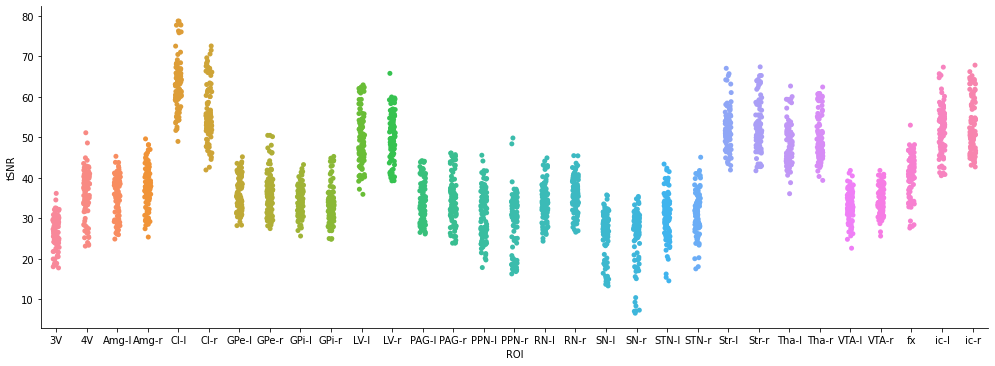

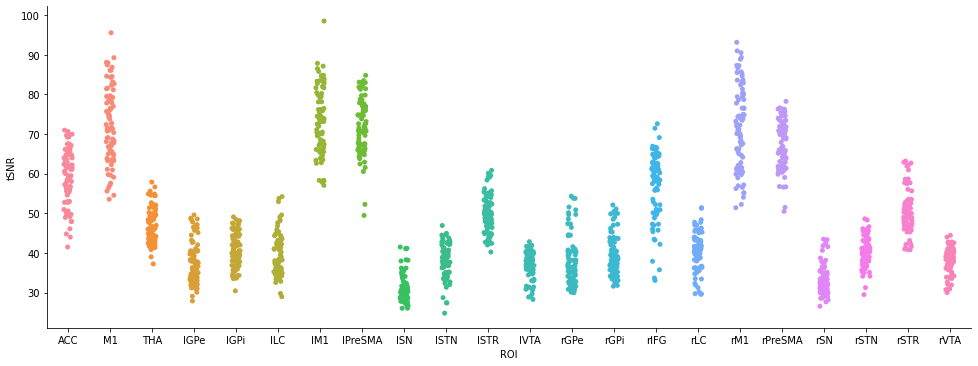

In [15]:
## All tSNR estimates found

for atlas_name in ['MASSP', 'ATAG']:
    all_tsnr_tables_fn = sorted(glob.glob(f'/home/Public/trondheim/derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table.to_csv(f'/home/Public/trondheim/derivatives/tsnr/all_tsnrs_{atlas_name}_table.tsv', sep='\t')
    all_tsnr_table

    fg = sns.catplot(x='ROI', y='tSNR', data=all_tsnr_table.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'))
    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'/home/Public/trondheim/figures/tsnr-{atlas_name}.pdf', bbox_inches='tight')

    display(all_tsnr_table)

### let's also register VTA and SN masks to mni09c to overlay them 

In [21]:

# warp MNI09b 0p5mm to MNI09cAsym 1mm template 
mni09b_brain = '/home/atrutti1/Documents/trondheim/LC_ICA/vta_mni09b/templates/ahead_final_med_r1map_n104_mni09b.nii.gz'

mni09c_brain= '/home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
registration_dir = '/home/atrutti1/Documents/trondheim/LC_ICA/registration/mni09b'

### Register MNI05 1mm to MNI09c (syn)
syn_res = embedded_antsreg(source_image=mni09b_brain,
                           target_image=mni09c_brain,
                           output_dir=registration_dir,
                           file_name='mni09b_to_mni09c',
                           save_data=True, 
                           overwrite=False)


#worked


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to /home/atrutti1/Documents/trondheim/LC_ICA/registration/mni09b/

Saving /home/atrutti1/Documents/trondheim/LC_ICA/registration/mni09b/mni09b_to_mni09c_tmp_srccoord.nii.gz

Saving /home/atrutti1/Documents/trondheim/LC_ICA/registration/mni09b/mni09b_to_mni09c_tmp_trgcoord.nii.gz
registering /home/atrutti1/Documents/trondheim/LC_ICA/vta_mni09b/templates/ahead_final_med_r1map_n104_mni09b.nii.gz
 to /home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output mni09b_to_mni09c_tmp_syn --transform SyN[0.2, 4.0, 3.0] --metric MI[/home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii, /home/atrutti1/Document

In [23]:

# apply same warp to vta mask


roi_dict_mni09b = {
    'lVTA': '../vta_mni09b/atlas-vta_hem-l_proba-27_mni09b.nii.gz',
    'rVTA': '../vta_mni09b/atlas-vta_hem-r_proba-27_mni09b.nii.gz',

}

#mapping1 = registration_dir + '/mni05_0p4_to_mni05_1p0_ants-map.nii.gz'
mapping2 = registration_dir + '/mni09b_to_mni09c_ants-map.nii.gz'

redo = False
final_masks_mni09c_1mm = '../vta_mni09b/final_masks_mni09c_1mm'

if not os.path.exists(final_masks_mni09c_1mm):
    os.makedirs(final_masks_mni09c_1mm)

for mask, fn in roi_dict_mni09b.items():
    if 'PreSMA' in mask:
        # two mappings
        apply_coordinate_mappings(fn, mapping1=mapping1, mapping2=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)
    else:
        # single mapping
        apply_coordinate_mappings(fn, mapping1=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ../vta_mni09b/final_masks_mni09c_1mm/

Saving ../vta_mni09b/final_masks_mni09c_1mm/lVTA_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ../vta_mni09b/final_masks_mni09c_1mm/

Saving ../vta_mni09b/final_masks_mni09c_1mm/rVTA_def-img.nii.gz


In [24]:

# warp MNI09b 0p5mm to MNI09cAsym 1mm template 
mni05_brain = '/home/atrutti1/Documents/trondheim/LC_ICA/sn_mni05/MNI152_T1_0.5mm_brain.nii.gz'

mni09c_brain= '/home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
registration_dir = '/home/atrutti1/Documents/trondheim/LC_ICA/registration/'

### Register MNI05 1mm to MNI09c (syn)
syn_res = embedded_antsreg(source_image=mni05_brain,
                           target_image=mni09c_brain,
                           output_dir=registration_dir,
                           file_name='mni152_0p5_to_mni09c',
                           save_data=True, 
                           overwrite=False)


#worked


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to /home/atrutti1/Documents/trondheim/LC_ICA/registration/MNI152_T1_0.5mm_brain/

Saving /home/atrutti1/Documents/trondheim/LC_ICA/registration/MNI152_T1_0.5mm_brain/mni152_0p5_to_mni09c_tmp_srccoord.nii.gz

Saving /home/atrutti1/Documents/trondheim/LC_ICA/registration/MNI152_T1_0.5mm_brain/mni152_0p5_to_mni09c_tmp_trgcoord.nii.gz
registering /home/atrutti1/Documents/trondheim/LC_ICA/sn_mni05/MNI152_T1_0.5mm_brain.nii.gz
 to /home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output mni152_0p5_to_mni09c_tmp_syn --transform SyN[0.2, 4.0, 3.0] --metric MI[/home/atrutti1/Documents/trondheim/LC_ICA/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_b

In [25]:

# apply same warp to SN mask


roi_dict_mni152_05 = {
    'lSN': '../sn_mni05/SN_L_prob_mni_non_linear_young.nii.gz',
    'rSN': '../sn_mni05/SN_R_prob_mni_non_linear_young.nii.gz'

}

#mapping1 = registration_dir + '/mni05_0p4_to_mni05_1p0_ants-map.nii.gz'
mapping2 = registration_dir + '/mni152_0p5_to_mni09c_ants-map.nii.gz'

redo = False
final_masks_mni09c_1mm = '../sn_mni05/final_masks_mni09c_1mm'

if not os.path.exists(final_masks_mni09c_1mm):
    os.makedirs(final_masks_mni09c_1mm)

for mask, fn in roi_dict_mni152_05.items():
    if 'PreSMA' in mask:
        # two mappings
        apply_coordinate_mappings(fn, mapping1=mapping1, mapping2=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)
    else:
        # single mapping
        apply_coordinate_mappings(fn, mapping1=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ../sn_mni05/final_masks_mni09c_1mm/

Saving ../sn_mni05/final_masks_mni09c_1mm/lSN_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ../sn_mni05/final_masks_mni09c_1mm/

Saving ../sn_mni05/final_masks_mni09c_1mm/rSN_def-img.nii.gz


In [ ]:
# downsample all masks in 1mm to 1p5mm


# 7 downsample resulting MNI09c brain to 1.5mm 

##  MNI09c -> MNI09c 1p5mm (BOLD-resolution)
#Select any BOLD-image (that was registered to MNI09c-space) and run embedded_syn without any iterations to resample in 1p5mm space

ref_bold = '/home/Public/trondheim/derivatives/fmriprep_anat/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz'
#not the bold run but the *_boldref.nii.gz

syn_res = embedded_antsreg(source_image=mni09c_brain,
                           target_image=ref_bold,
                           rigid_iterations=0, 
                           coarse_iterations=0,
                           medium_iterations=0,
                           fine_iterations=0,
                           run_rigid=True,
                           run_syn=False,
                           run_affine=False,
                           save_data=True,
                           output_dir=registration_dir,
                           file_name='mni09c_1mm_to_mni09c_1p5mm',
                           overwrite=True)

#probably won't work 
# mni09c_2_1p5mm_svg = make_report(fixed_image=ref_bold, 
#                                  moving_image='../registration/mni09c_to_mni09c_1p5mm_ants-def.nii.gz', #syn_res['transformed_source'],
#                                  output_dir=registration_dir, fn='mni09c_to_mni09c_1p5mm.svg')
# from IPython.display import SVG, display
# display(SVG(mni09c_2_1p6mm_svg))

In [27]:
# vta  

registration_dir = '/home/atrutti1/Documents/trondheim/LC_ICA/registration/'


### Apply transforms to each mask; save again
# mapping1 = os.path.join(registration_dir, 'mni05_0p4_to_mni05_1p0_ants-map.nii.gz')
mapping2 = os.path.join(registration_dir, 'mni09b/mni09b_to_mni09c_ants-map.nii.gz')
mapping3 = os.path.join(registration_dir, 'mni09c_1mm_to_mni09c_1p5mm_ants-map.nii.gz')

final_masks_mni09c_1p5mm = '../registration/mni09b/final_masks_mni09c_1p5mm'
if not os.path.exists(final_masks_mni09c_1p5mm):
    os.makedirs(final_masks_mni09c_1p5mm)

redo=True
for mask, fn in roi_dict_mni09b.items():
    if 'PreSMA' in mask:
        apply_coordinate_mappings(fn, 
                          mapping1=mapping1,      # 05 p4 -> 05 1mm
                          mapping2=mapping2,      # 05 -> 09a
                          mapping3=mapping3,      # 09a 1mm -> 09a 1.6mm
                          save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                          overwrite=redo, padding='zero')
    else:
        apply_coordinate_mappings(fn, 
                                  mapping1=mapping2,   # 05 -> 09a
                                  mapping2=mapping3,   # 09a -> 09a 1.6mm
                                  save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                                  overwrite=redo, padding="zero")


Apply coordinate mappings

Outputs will be saved to ../registration/mni09b/final_masks_mni09c_1p5mm/

Saving ../registration/mni09b/final_masks_mni09c_1p5mm/lVTA_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ../registration/mni09b/final_masks_mni09c_1p5mm/

Saving ../registration/mni09b/final_masks_mni09c_1p5mm/rVTA_def-img.nii.gz


In [28]:
# sn  


### Apply transforms to each mask; save again
# mapping1 = os.path.join(registration_dir, 'mni05_0p4_to_mni05_1p0_ants-map.nii.gz')
mapping2 = os.path.join(registration_dir, 'MNI152_T1_0.5mm_brain/mni152_0p5_to_mni09c_ants-map.nii.gz')
mapping3 = os.path.join(registration_dir, 'mni09c_1mm_to_mni09c_1p5mm_ants-map.nii.gz')

final_masks_mni152_1p5mm = '../registration/mni152/final_masks_mni09c_1p5mm'
if not os.path.exists(final_masks_mni09c_1p5mm):
    os.makedirs(final_masks_mni09c_1p5mm)

redo=True
for mask, fn in roi_dict_mni152_05.items():
    if 'PreSMA' in mask:
        apply_coordinate_mappings(fn, 
                          mapping1=mapping1,      # 05 p4 -> 05 1mm
                          mapping2=mapping2,      # 05 -> 09a
                          mapping3=mapping3,      # 09a 1mm -> 09a 1.6mm
                          save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                          overwrite=redo, padding='zero')
    else:
        apply_coordinate_mappings(fn, 
                                  mapping1=mapping2,   # 05 -> 09a
                                  mapping2=mapping3,   # 09a -> 09a 1.6mm
                                  save_data=True, output_dir=final_masks_mni09c_1p5mm, file_name=mask,
                                  overwrite=redo, padding="zero")


Apply coordinate mappings

Outputs will be saved to ../registration/mni09b/final_masks_mni09c_1p5mm/

Saving ../registration/mni09b/final_masks_mni09c_1p5mm/lSN_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ../registration/mni09b/final_masks_mni09c_1p5mm/

Saving ../registration/mni09b/final_masks_mni09c_1p5mm/rSN_def-img.nii.gz


### output:
now all masks are in group space (MNI09c asym 1.5mm --> BOLD res)

so now we can overlay and plot them all

### below not required as only one mask (brainstem mask in MNI) is required 

In [ ]:
### Apply transforms to each mask; save again
mapping1 = os.path.join(registration_dir, 'mni05_0p4_to_mni05_1p0_ants-map.nii.gz')
mapping2 = os.path.join(registration_dir, 'mni05_to_mni09c_ants-map.nii.gz')
mapping3 = os.path.join(registration_dir, 'mni09c_to_mni09c_1p6mm_ants-map.nii.gz')
# mapping_mni05_0p4_2_1mm = './masks/registration/MNI152_T1_04mm_brain_ants-map.nii.gz'
# mapping_mni05_1mm_2_mni09a = './masks/registration/MNI152_T1_1mm_brain_ants-map.nii.gz'
# mapping_mni09a_2_1p6mm = './masks/registration/MNI09a_2_1p6mm_ants-map.nii.gz'

final_masks_mni09c_1p6mm = './masks/final_masks_mni09c_1p6mm'
if not os.path.exists(final_masks_mni09c_1p6mm):
    os.makedirs(final_masks_mni09c_1p6mm)

redo=True
for mask, fn in roi_dict_mni05.items():
    if 'PreSMA' in mask:
        apply_coordinate_mappings(fn, 
                          mapping1=mapping1,      # 05 p4 -> 05 1mm
                          mapping2=mapping2,      # 05 -> 09a
                          mapping3=mapping3,      # 09a 1mm -> 09a 1.6mm
                          save_data=True, output_dir=final_masks_mni09c_1p6mm, file_name=mask,
                          overwrite=redo, padding='zero')
    else:
        apply_coordinate_mappings(fn, 
                                  mapping1=mapping2,   # 05 -> 09a
                                  mapping2=mapping3,   # 09a -> 09a 1.6mm
                                  save_data=True, output_dir=final_masks_mni09c_1p6mm, file_name=mask,
                                  overwrite=redo, padding="zero")

In [23]:
# utility function to checkout registration results
def make_report(fixed_image, moving_image, output_dir=os.getcwd(), fn='report.svg',
               compress_report=False):
    from nipype.interfaces.base import File
    _fixed_image = fixed_image
    _moving_image = moving_image
    _fixed_image_mask = None
    _fixed_image_label = "fixed"
    _moving_image_label = "moving"
    _contour = None
    #    _out_report = File('report.svg', usedefault=True, desc='filename for the visual report')#'report.svg'
    _out_report = os.path.abspath(os.path.join(output_dir, fn))

    from niworkflows.viz.utils import plot_registration, compose_view, cuts_from_bbox
    from nilearn.masking import apply_mask, unmask
    from nilearn.image import threshold_img, load_img

    fixed_image_nii = load_img(_fixed_image)  # template
    moving_image_nii = load_img(_moving_image)  # source
    contour_nii = load_img(_contour) if _contour is not None else None

    if _fixed_image_mask:
        fixed_image_nii = unmask(apply_mask(fixed_image_nii,
                                            _fixed_image_mask),
                                 _fixed_image_mask)
        # since the moving image is already in the fixed image space we
        # should apply the same mask
        moving_image_nii = unmask(apply_mask(moving_image_nii,
                                             _fixed_image_mask),
                                  _fixed_image_mask)
        mask_nii = load_img(_fixed_image_mask)
    else:
        mask_nii = threshold_img(fixed_image_nii, 1e-3)

    n_cuts = 7
    if not _fixed_image_mask and contour_nii:
        cuts = cuts_from_bbox(contour_nii, cuts=n_cuts)
    else:
        cuts = cuts_from_bbox(mask_nii, cuts=n_cuts)

    # Call composer
    compose_view(
        plot_registration(fixed_image_nii, 'fixed-image',
                          estimate_brightness=True,
                          cuts=cuts,
                          label=_fixed_image_label,
                          contour=contour_nii,
                          compress=compress_report),
        plot_registration(moving_image_nii, 'moving-image',
                          estimate_brightness=True,
                          cuts=cuts,
                          label=_moving_image_label,
                          contour=contour_nii,
                          compress=compress_report),
        out_file=_out_report
    )
    return _out_report

In [28]:

### Checkout registration quality
mni05_1mm_2_mni09c_svg = make_report(fixed_image=mni09c_brain, moving_image= '../registration/mni05_to_mni09c_ants-def0.nii.gz', #syn_res['transformed_source'],
                                     output_dir=registration_dir, fn='mni05_1mm_2_mni09c.svg')
from IPython.display import SVG, display
display(SVG(mni05_1mm_2_mni09c_svg))

TypeError: moveto() got an unexpected keyword argument 'scale'